In [1]:
import scipy.stats as stats
import torch
import numpy as np
import matplotlib.pyplot as plt
toCPU=lambda x: x.detach().cpu().numpy()
toCUDA=lambda x: torch.tensor(x).cuda()

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class gaussian_kde(nn.Module):
    def __init__(self,X_min,X_max,bins,sigma):
        super(gaussian_kde, self).__init__()
        self.X_min=X_min
        self.X_max=X_max
        self.bins=bins
        self.sigma=sigma
        self.delta = float(X_max - X_min) / float(bins)
        self.centers = float(X_min) + self.delta * (torch.arange(bins).float() + 0.5).cuda()
    
    def forward(self,x):
        # 计算self.centers到每一个x的距离
        # x是网络的输出，或ground truth降雨
        # 输出每一个center处的概率密度
        x = torch.unsqueeze(x, 0) - torch.unsqueeze(self.centers, 1)
        x = torch.exp(-0.5*(x/self.sigma)**2) / (self.sigma * np.sqrt(np.pi*2)*self.bins)
        x = x.sum(dim=1)
        return x

class KL_loss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, P, Q):
        ctx.save_for_backward(P,Q)
        KL=torch.sum( (P*torch.log(P)-P*torch.log(Q)) )
        return KL

    @staticmethod
    def backward(ctx, grad_output):
        # 过滤掉梯度中的nan与inf
        P,Q = ctx.saved_tensors
        grad=-P/Q # 这是KL对于Q的梯度
        mask1=torch.isinf(grad)
        mask2=torch.isnan(grad)
        mask=mask1|mask2
        grad[mask]=0
        return None, grad

In [ ]:
想请你简单看一下我KL loss模块的代码，是不是和你的做法一致。我检查一天多了，在测试的时候没有问题，但一训练就有问题，卡住了。我不知道你是不是数学pytorch，你有时间的话帮我看一眼呗。如果你不熟悉pytorch的话，那就算了，谢谢啊。

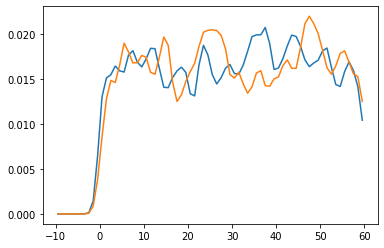

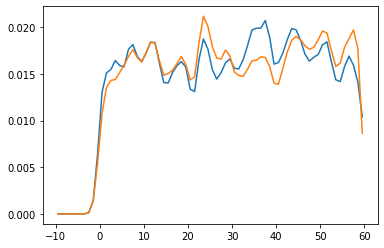

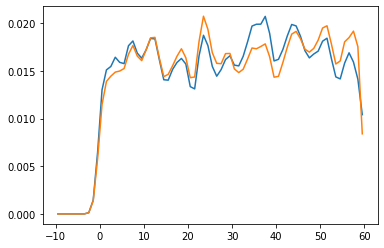

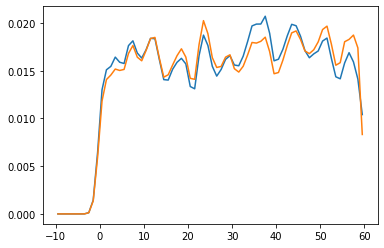

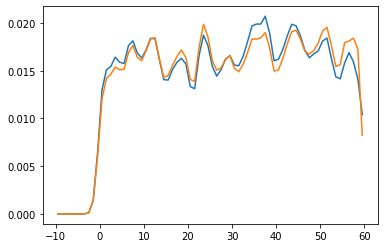

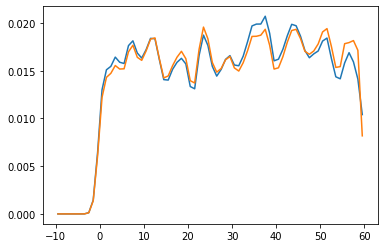

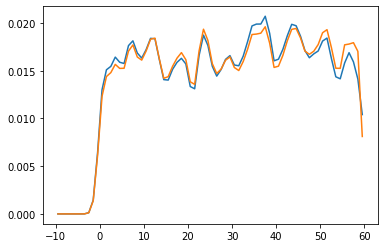

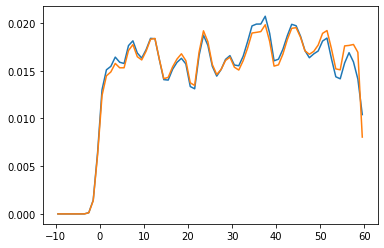

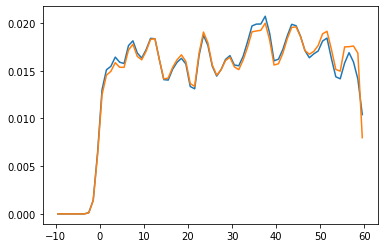

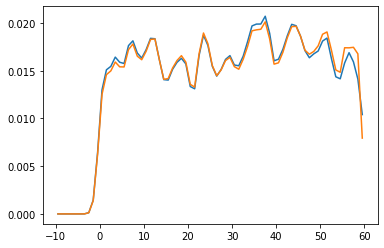

In [6]:
KL = KL_loss.apply
KDE=gaussian_kde(X_min=-10,X_max=60,bins=70,sigma=1)

##准备数据
pred=nn.Parameter(torch.rand(1024)).cuda()*60
pred.retain_grad()
y_true=torch.rand(1024).cuda()*60

## 手动更新pred
for epoch in range(500):
    P=KDE(y_true)
    Q=KDE(pred)
    kl=KL(P,Q)
    kl.backward(retain_graph=True)
    pred.data=pred.data-10*pred.grad
    pred.grad.zero_()
    
    if epoch%50==0:
        x=KDE.centers
        plt.plot(toCPU(x),toCPU(P)/np.sum(toCPU(P)))
        plt.plot(toCPU(x),toCPU(Q)/np.sum(toCPU(Q)))
        plt.show()